<a href="https://colab.research.google.com/github/htapiagroup/sistemas-distribuidos-evaluacion-intersemestral-BaezCrdrm/blob/Avance/MCA_SistDist_Ex1_SBH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas Distribuidos

## Instrucciones

### Primera evaluacion

Se evaluaran los siguientes puntos:

#### Importar datos

1. Adquirir los datos.
> * El conjunto de datos con el que van a trabajar esta disponibles en [este enlace](https://archive.org/download/nycTaxiTripData2013/trip_data.7z) y consiste en 12 archivos de texto que tiene informacion del viajes de taxis en la ciudad de NY durante el 2013.
> * En la red interna de LANIA usando cable la descarga del archivo comprimido desde el enlace tomó entre 5 y 10 minutos. Tomen sus provisiones
> * El archivo comprimido tiene un tamaño de aproximadamente 4G, el tamaño de archivo mensual oscila entre 2.0 y 2.5G. La base de datos completa es de aproximadamente 30G.
2. Una vez descargado el archivo pueden descomprimirlo usando la siguiente instruccion
>` !7z x trip_data.7z -o/content/`
sin embargo si intentan descomprimir todos los archivos en su sesion se van a terminar el espacio de disco disponible. En esta practica solo van a trabajar con datos correspondientes a los primeros cuatro meses. 
3. Responder las siguientes preguntas:
   1. Cuantas columnas contiene cada archivo de datos descomprimido
   2. Cuantos renglones tiene cada archivo
4. Identificar si existen renglones con errores en los datos, por ejemplo si hay columnas de mas (o de menos), si hay campos vacios, etc. Si se detectan renglones con errores:
    1. indicar claramente cuantos son los renglones con errores y a que archivos corresponden
    2. crear un nuevo conjunto de datos con los errores eliminados
5. Crear un `DataFrame` usando la libreria `pandas` y responder lo siguiente:
   1. Indicar el tiempo en segundos, que  tarda la libreria `pandas` en leer un archivo a un  `DataFrame`
   2. Cual es la huella de memoria del proceso usado para generar el objeto `DataFrame`
   2. Cuanta memoria del sistema se usa para crear el objeto anterior
   3. Indicar el tiempo que tarda `pandas` en obtener el promedio de la distancia de viaje (`trip_distance`)
6. Todos los pasos siguientes deben **realizarse** usando la libreria `dask`
   3. Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (`trip_distance`)
   3. Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (`trip_time_in_secs`)
   4. Con las columnas `pickup_datetime` y `dropoff_datetime` como objetos temporales, crear una nueva columna en los dataframes que se llame `duracion` y compararla renglon a renglon con la columna `trip_time_in_secs`
   5. Definir un `viaje_largo` como aquellos en los que la duracion del viaje (`trip_time_in_secs`) sea mayor a 20 minutos.
7. Contar el numero de viajes largos en cada archivo
8. De los viajes largos, identificar el numero de taxis diferentes (la columna `medallion` contiene un numeroque identificada a cada uno de los vehiculos). Que vehiculos son los que mas viajes realizan en cada mes? Son el mismo vehiculo?
9. Hacer una grafica temporal del numero total de pasajeros agregados por dias de la semana y despues por horas del dia. Sugerencia: agregar por el correspondiente periodo temporal y graficar. Que pueden observar de las graficas?
10. Elegir el vehiculo con mas viajes en cada mes y graficar en un mapa los sitios donde se suben pasajeros agrupados por
   * dia de la semana (un color distinto para cada dia)
   * hora del dia (un color distinto para cada intervalo de cuatro horas,00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)
11. Repetir para las posiciones donde se bajan los pasajeros para el mismo vehiculo.


# Desarrollo y comprobación
Este segmento contiene toda la información realizada para responder las preguntas establecidas.

In [0]:
import psutil, os
import pandas as pd, time
import dask
import dask.dataframe as dd
from dask import delayed
import matplotlib.pyplot as plt

La función `huella_memoria` fue obtenida de las libretas de cuadernos anteriores.

In [0]:
def huella_memoria():
    ''' Regresa la juella de memoria en MB usada por un proceso de Python'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024**2)

## 1. Adquirir los datos

Agregar Google Drive para no tener que descargar los datos.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
cd /content/gdrive/

/content/gdrive


In [5]:
ls

'My Drive'/


In [6]:
pwd

'/content/gdrive'

In [7]:
cd /content/gdrive/My\ Drive/SD

/content/gdrive/My Drive/SD


Obtiene y descomprime los datos

In [0]:
if not os.path.exists("/content/gdrive/My Drive/SD/trip_data.7z"):
    comando = "wget https://archive.org/download/nycTaxiTripData2013/trip_data.7z && 7z x trip_data.7z"
    os.system(comando)

In [0]:
ruta_principal = '/content/gdrive/My Drive/SD/'
ruta_datos = ruta_principal + "Datos/"
if not os.path.exists(ruta_datos):
    os.mkdir(ruta_datos)

In [0]:
total_archivos = 12
archivo_temp = "trip_data_{}.csv"
ruta = ruta_datos + archivo_temp
archivos = [ruta.format(k) for k in range(1, total_archivos + 1)]
ruta = ruta_principal + "temp/" + archivo_temp
archivos_temporales = [ruta.format(k) for k in range(1, total_archivos + 1)]
comando = "7z e '/content/gdrive/My Drive/SD/trip_data.7z' -o/content/gdrive/My Drive/SD/temp' " + archivo_temp
comandos = [comando.format(k) for k in range(1, total_archivos + 1)]

In [0]:
import numpy as np
ac = np.array([archivos, comandos, archivos_temporales]).T
ac = ac.tolist()

In [12]:
for i in ac:
    print("Imprimio")
    print(i)

Imprimio
['/content/gdrive/My Drive/SD/Datos/trip_data_1.csv', "7z e '/content/gdrive/My Drive/SD/trip_data.7z' -o/content/gdrive/My Drive/SD/temp' trip_data_1.csv", '/content/gdrive/My Drive/SD/temp/trip_data_1.csv']
Imprimio
['/content/gdrive/My Drive/SD/Datos/trip_data_2.csv', "7z e '/content/gdrive/My Drive/SD/trip_data.7z' -o/content/gdrive/My Drive/SD/temp' trip_data_2.csv", '/content/gdrive/My Drive/SD/temp/trip_data_2.csv']
Imprimio
['/content/gdrive/My Drive/SD/Datos/trip_data_3.csv', "7z e '/content/gdrive/My Drive/SD/trip_data.7z' -o/content/gdrive/My Drive/SD/temp' trip_data_3.csv", '/content/gdrive/My Drive/SD/temp/trip_data_3.csv']
Imprimio
['/content/gdrive/My Drive/SD/Datos/trip_data_4.csv', "7z e '/content/gdrive/My Drive/SD/trip_data.7z' -o/content/gdrive/My Drive/SD/temp' trip_data_4.csv", '/content/gdrive/My Drive/SD/temp/trip_data_4.csv']
Imprimio
['/content/gdrive/My Drive/SD/Datos/trip_data_5.csv', "7z e '/content/gdrive/My Drive/SD/trip_data.7z' -o/content/gdriv

In [13]:
if os.path.exists('/content/gdrive/My Drive/SD/Datos/trip_data_7.csv'):
    print(True)
else:
    print(False)

True


## Pandas Versión 1
Un sólo archivo. Para entrega del [martes 18 de junio](https://github.com/htapiagroup/sistemas-distribuidos-evaluacion-intersemestral-BaezCrdrm/blob/0c178f606223985b407d9e467ec42823b555fbd7/MCA_SistDist_Ex1_SBH.ipynb).

### Colaboradores de esta sección
- Luis Daniel Hernandez Jimenez
- Alexis Martínez Arteaga
- Jose David Cobos Trujillo
- Lorrain Eugenio Giddings Soto
- Yoselin Araceli Campos Sacramento
- Ana Margarita Reyes Hernandez
- Joaquin Aguilar Hernandez
- Georgina Valenzuela Carrasco
- Horacio Tapia McClung

### 2. Descomprime datos

#### Descomprime un sólo archivo de datos descargados.

In [0]:
!7z e trip_data.7z -o/content/gdrive/My\ Drive/Colab\ Notebooks/Evaluacion/Data trip_data_1.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4102781969 bytes (3913 MiB)

Extracting archive: trip_data.7z
--
Path = trip_data.7z
Type = 7z
Physical Size = 4102781969
Headers Size = 433
Method = LZMA:24
Solid = -
Blocks = 12

  0%      0% - trip_data_1.csv                        1% - trip_data_1.csv                        2% - trip_data_1.csv                        3% - trip_data_1.csv                      
Archives with Errors: 1



Break signaled


In [0]:
cd Data

/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data


### 5. Crear un `DataFrame` usando la libreria `pandas`.

In [0]:
# Tiempo y memoria
t_start = time.time()
mem_antes = huella_memoria()

df = pd.read_csv('trip_data_1.csv')

# Tiempo y memoria
mem_despues = huella_memoria()
t_end = time.time()

### 3. Preguntas

Contar dimensiones del dataframe.

Hay `14776615` registros y `14` variables/columnas.

In [0]:
df.shape

(14776615, 14)

### 4. Identificar si existen renglones con errores en los datos, por ejemplo si hay columnas de mas (o de menos), si hay campos vacios, etc. Si se detectan renglones con errores:

In [0]:
df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


#### 0. Verificar errores
Crear un nuevo conjunto de datos con los errores eliminados.

Verificar errores en el Dataframe y limpiar los errores nulos y NaN que pudieran afectar al DataFrame.

##### Limpiar data frame

In [0]:
df.isna().sum()

medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7326207
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude          86
dropoff_latitude           86
dtype: int64

In [0]:
df = df.dropna(how='all', subset=['dropoff_longitude', 'dropoff_latitude'])

##### Eliminar columnas

In [0]:
df = df.drop('store_and_fwd_flag', axis=1)

In [0]:
df.isna().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64

**Al limpiar el resultado** es igual a:

14776529 registros y 13 columnas/variables.

In [0]:
df.shape

(14776529, 13)

#### 5.1 Indicar el tiempo en segundos, que  tarda la libreria `pandas` en leer un archivo a un  `DataFrame.

In [0]:
print('Tiemo de lectura: {} s'.format(t_end - t_start))

Tiemo de lectura: 102.31801748275757 s


#### 5.2 Cual es la huella de memoria del proceso usado para generar el objeto `DataFrame.

In [0]:
print('Huella de memoria: {} MB'.format(mem_despues - mem_antes))

Huella de memoria: 4962.84765625 MB


#### 5.3 Cuanta memoria del sistema se usa para crear el objeto anterior.

_En colaboración con **David Cobos**_

In [0]:
print('Memoria del sistema: {} MB'.format(huella_memoria()))

Memoria del sistema: 6348.74609375 MB


#### 5.4 Indicar el tiempo que tarda `pandas` en obtener el promedio de la distancia de viaje (`trip_distance`).

_En colaboración con **Alexis Martínez**_

In [0]:
# Tiempo y memoria
t_start = time.time()
mem_antes = huella_memoria()

no_ceros = (df['trip_distance'] != 0)
promedio_total_distancia_viaje = no_ceros.mean()

# Tiempo y memoria
mem_despues = huella_memoria()
t_end = time.time()

In [0]:
print('Tiemo de lectura: {} s'.format(t_end - t_start))
# print('Uso de memoria: {} MB'.format(mem_despues - mem_antes))

Tiemo de lectura: 0.0654911994934082 s


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Pandas Versión 2
Para todos los archivos.

### Ejecución

#### Obtener los datos
Descargar, descomprimir y transformar los datos.

In [0]:
ruta_datos

'/content/gdrive/My Drive/SD/Datos/'

In [0]:
if not os.path.exists(ruta_principal + "temp"):
    os.mkdir(ruta_principal + "temp")

Carga los datos al disco. Anteriormente descomprimía y eliminaba columnas de los datasets de memoria, pero debido al tiempo que tomaba se decidió tomar la aproximación de _Adrian Sosa_ para llevar a cabo estos pasos.

In [0]:
def cargar_nuevos_csv(k):
    ''' Función que permite descomprimir y limpiar los archivos usando Pandas '''
    archivo = k[2]
    
    #if not os.path.exists(archivo):
        #os.system(k[1])
        
    try:
        df = pd.read_csv(archivo, usecols=["medallion",  "pickup_datetime", "dropoff_datetime", "passenger_count", "trip_time_in_secs", "trip_distance", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"])
    except :
        pass
    try:
        df = pd.read_csv(archivo, usecols=["medallion",  " pickup_datetime", " dropoff_datetime", " passenger_count", " trip_time_in_secs", " trip_distance", " pickup_longitude", " pickup_latitude", " dropoff_longitude", " dropoff_latitude"])
    except :
        pass
        
    # df = pd.read_csv(archivo, dtype="str")
    df.columns = df.columns.str.strip()
    forma = df.shape
    
    # Se eliminan las columnas
    '''
    df = df.drop('hack_license', axis=1)
    df = df.drop('vendor_id', axis=1)
    df = df.drop('rate_code', axis=1)
    df = df.drop('store_and_fwd_flag', axis=1)
    '''
    df = df.dropna(how='all', subset=['dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'trip_distance', "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"])
    
    # Convierte datos
    '''
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    df['passenger_count'] = df['passenger_count'].astype(int)
    '''
    
    # Instrucción por Daniel Hernandez
    df = df.drop(df[df.passenger_count > 9].index)
    df = df.drop(df[df.passenger_count <= 0].index)
    df = df.drop(df[df.trip_distance <= 0].index)
    df = df.drop(df[df.trip_distance > 5000].index)
    
    '''df = df.drop(df[abs(df.pickup_longitude)>180].index)
    df = df.drop(df[abs(df.pickup_latitude)>90].index)
    df = df.drop(df[abs(df.dropoff_longitude)>180].index)
    df = df.drop(df[abs(df.dropoff_latitude)>90].index)'''
    
    # df['trip_time_in_secs'] = df['trip_time_in_secs'].astype(float)
    
    # Elimina cualquier archivo existente
    if os.path.exists(k[0]):
        os.remove(k[0])
    
    df.to_csv(k[0])
    
    # os.remove(archivo)
    
    df = None
    return forma

_**Ejecutar únicamente si no se tienen los archivos**_

In [0]:
formas = []
for k in ac:
    forma = cargar_nuevos_csv(k)
    formas.append(forma)
    
print(os.listdir(ruta_datos))

['trip_data_1.csv', 'trip_data_2.csv', 'trip_data_3.csv', 'trip_data_4.csv', 'trip_data_5.csv', 'trip_data_6.csv', 'trip_data_7.csv', 'trip_data_8.csv', 'trip_data_9.csv', 'trip_data_10.csv', 'trip_data_11.csv', 'trip_data_12.csv']


#### Obtener DataFrames
Dataframes de los primeros 4 archivos
1. Indicar el tiempo en segundos, que  tarda la libreria `pandas` en leer un archivo a un  `DataFrame`
2. Cual es la huella de memoria del proceso usado para generar el objeto `DataFrame`
2. Cuanta memoria del sistema se usa para crear el objeto anterior
3. Indicar el tiempo que tarda `pandas` en obtener el promedio de la distancia de viaje (`trip_distance`)

In [0]:
tiempos_carga = []
memoria_carga = []
resultado_prom_pandas = []
tiempos_prom_pandas = []

In [0]:
for archivo in ac:
    t_start = time.time()
    mem_antes = huella_memoria()
    
    df = pd.read_csv(archivo[0])
    
    t_end = time.time()
    mem_despues = huella_memoria()
    memoria_carga.append(mem_despues - mem_antes)
    tiempos_carga.append(t_end - t_start)
    
    t_start = time.time()
    prom = df['trip_distance'].mean()
    resultado_prom_pandas.append(prom)
    t_end = time.time()
    tiempos_prom_pandas.append(t_end - t_start)
    
    df = None

### Resultados
A la carga de 12 archivos en Pandas Dataframes

In [0]:
resp_template = ("Para el mes {0}, el promedio de la distancia de viaje \"trip_distance\" es de {1} millas.\n" +
                 "El DataFrame cuenta con 2 dimensiones, {5} registros y {6} columnas tras la limpieza que se realizó en la carga del archivo al disco duro.\n" + 
                 "El proceso utilizó {2} MB de memoria.\nTomó {3} s en cargarse el DataFrame y {4} en obtener el promedio.\n")
for i in range(len(resultado_prom_pandas)):
    print(resp_template.format(i + 1, round(resultado_prom_pandas[i], 4), memoria_carga[i], round(tiempos_carga[i], 2), round(tiempos_prom_pandas[i], 2), formas[i][0], formas[i][1]))

Para el mes 1, el promedio de la distancia de viaje "trip_distance" es de 2.7867 millas.
El DataFrame cuenta con 2 dimensiones, 14776615 registros y 10 columnas tras la limpieza que se realizó en la carga del archivo al disco duro.
El proceso utilizó -304.89453125 MB de memoria.
Tomó 49.28 s en cargarse el DataFrame y 0.03 en obtener el promedio.

Para el mes 2, el promedio de la distancia de viaje "trip_distance" es de 2.7561 millas.
El DataFrame cuenta con 2 dimensiones, 13990176 registros y 10 columnas tras la limpieza que se realizó en la carga del archivo al disco duro.
El proceso utilizó 222.80078125 MB de memoria.
Tomó 46.64 s en cargarse el DataFrame y 0.02 en obtener el promedio.

Para el mes 3, el promedio de la distancia de viaje "trip_distance" es de 2.8567 millas.
El DataFrame cuenta con 2 dimensiones, 15749228 registros y 10 columnas tras la limpieza que se realizó en la carga del archivo al disco duro.
El proceso utilizó 822.39453125 MB de memoria.
Tomó 52.09 s en cargar

## 6. Dask

Todos los pasos siguientes deben **realizarse** usando la libreria `dask`
   3. Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (`trip_distance`)
   3. Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (`trip_time_in_secs`)
   4. Con las columnas `pickup_datetime` y `dropoff_datetime` como objetos temporales, crear una nueva columna en los dataframes que se llame `duracion` y compararla renglon a renglon con la columna `trip_time_in_secs`
   5. Definir un `viaje_largo` como aquellos en los que la duracion del viaje (`trip_time_in_secs`) sea mayor a 20 minutos.

### Ejecución

In [14]:
ruta_datos

'/content/gdrive/My Drive/SD/Datos/'

In [0]:
f = ruta_datos + "*.csv" # Todos los archivos
# f = ruta_datos + "trip_data_7.csv" # 1 archivo
# f = '/content/gdrive/My Drive/SD/Training/*.csv'

In [0]:
ddf = dd.read_csv(f, assume_missing=True, include_path_column=True)

Con las columnas `pickup_datetime` y `dropoff_datetime` como objetos temporales, crear una nueva columna en los dataframes que se llame duracion y compararla renglon a renglon con la columna `trip_time_in_secs`.

In [17]:
# pickup_datetime y dropoff_datetime
ddf['pickup_datetime'] = dd.to_datetime(ddf['pickup_datetime'])
ddf['dropoff_datetime'] = dd.to_datetime(ddf['dropoff_datetime'])
ddf['duracion'] = ddf['dropoff_datetime'] - ddf['pickup_datetime']
'''ddf['trip_time_in_secs'] = ddf['trip_time_in_secs'].astype(float)
ddf['pickup_longitude'] = ddf['pickup_longitude'].astype(float)
ddf['pickup_latitude'] = ddf['pickup_latitude'].astype(float)
ddf['dropoff_longitude'] = ddf['dropoff_longitude'].astype(float)
ddf['dropoff_latitude'] = ddf['dropoff_latitude'].astype(float)'''

"ddf['trip_time_in_secs'] = ddf['trip_time_in_secs'].astype(float)\nddf['pickup_longitude'] = ddf['pickup_longitude'].astype(float)\nddf['pickup_latitude'] = ddf['pickup_latitude'].astype(float)\nddf['dropoff_longitude'] = ddf['dropoff_longitude'].astype(float)\nddf['dropoff_latitude'] = ddf['dropoff_latitude'].astype(float)"

In [0]:
pdv = []
def promedio_distancia_viaje(data):
    data['trip_distance'] = data['trip_distance'].astype(float)
    prom_trip_distance = data['trip_distance'].mean()
    return prom_trip_distance

In [0]:
t_start = time.time()

prom_distancia = promedio_distancia_viaje(ddf).compute()

t_end = time.time()
tiempo_prom_distancia = t_end - t_start

In [0]:
print(prom_distancia)

2.9104131224134795


In [0]:
def promedio_tiempo_segundos(data):
    prom_trip_time_in_secs = data['trip_time_in_secs'].mean()
    return prom_trip_time_in_secs

In [0]:
t_start = time.time()

prom_tiempo = promedio_tiempo_segundos(ddf).compute()

t_end = time.time()
tiempo_prom_tiempo = t_end - t_start

In [0]:
print(prom_tiempo)

814.4180595949854


_No entendí este punto. Sí entendí que había que comparar los valores, pero no sé dónde almacenarlos._

In [0]:
# Pendiente: compararla renglon a renglon con la columna `trip_time_in_secs`
import datetime

In [0]:
a = datetime.timedelta(seconds=3)
print(a)

0:00:03


In [0]:
diferencias = ddf[ddf['trip_time_in_secs'] != ddf['duracion']]

In [0]:
total_diferencias = diferencias.count().compute()

In [0]:
total_diferencias = total_diferencias.trip_distance

Obtener viajes largos

In [0]:
viajes_largos = ddf[ddf.trip_time_in_secs > 1200]

In [0]:
prom.compute()

2.8060248225266404

In [0]:
size_vl = viajes_largos.count().compute()

In [0]:
ppd = pd.read_csv('/content/gdrive/My Drive/SD/temp/trip_data_7.csv')

In [0]:
f

'/content/gdrive/My Drive/SD/Datos/trip_data_7.csv'

In [0]:
ppd

,Unnamed: 0,medallion,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude


In [0]:
size_vl

Unnamed: 0           0
medallion            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
path                 0
duracion             0
dtype: int64

In [0]:
size_vl

Unnamed: 0           26518989
medallion            26518989
pickup_datetime      26518989
dropoff_datetime     26518989
passenger_count      26518989
trip_time_in_secs    26518989
trip_distance        26518989
pickup_longitude     26518989
pickup_latitude      26518989
dropoff_longitude    26518989
dropoff_latitude     26518989
path                 26518989
duracion             26518989
dtype: int64

### Resultados

Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje  (`trip_distance`)

In [0]:
print("El tiempo que Dask toma para procesar el tiempo promedio de la distancia de viaje es de {} s".format(round(tiempo_prom_distancia, 2)))

El tiempo que Dask toma para procesar el tiempo promedio de la distancia de viaje es de 511.94 s


Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (trip_time_in_secs)

In [0]:
print("El tiempo que Dask toma para procesar el tiempo promedio de la duración de viaje es de {} s".format(round(tiempo_prom_tiempo, 2)))

El tiempo que Dask toma para procesar el tiempo promedio de la duración de viaje es de 513.56 s


Con las columnas pickup_datetime y dropoff_datetime como objetos temporales, crear una nueva columna en los dataframes que se llame duracion y compararla renglon a renglon con la columna `trip_time_in_secs`.

_Interpretación de la comparación en colaboración con Adrian Sosa_

In [0]:
msg = ("Existen {} registros en los que la columna duracion y la columna tip_time_in_secs difieren.\n" +
      "Esta diferencia puede ser de unos cuantos segundos, por lo que para más información es necesario una interpretación diferente.")
print(msg.format(total_diferencias))

Existen 173176305 registros en los que la columna duracion y la columna tip_time_in_secs difieren.
Esta diferencia puede ser de unos cuantos segundos, por lo que para más información es necesario una interpretación diferente.


Definir un viaje_largo como aquellos en los que la duracion del viaje (trip_time_in_secs) sea mayor a 20 minutos.

In [0]:
print("Los registros del Dataframe de Viajes Largos son {}".format(size_vl))

## 7. Contar el numero de viajes largos en cada archivo

In [0]:
pa = viajes_largos.groupby('path')

In [0]:
cantidad_viajes_largos = pa.size().compute()

### Resultados

In [0]:
print("Cantidad de viajes largos por cada archivo")
print(cantidad_viajes_largos)

Cantidad de viajes largos por cada archivo
path
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_1.csv     1715237
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_10.csv    2545155
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_11.csv    2373698
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_12.csv    2428514
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_2.csv     1768887
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_3.csv     2111850
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_4.csv     2264701
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_5.csv     2552684
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_6.csv     2400513
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_7.csv     2084036
/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data/trip_data_8.csv     1919857
/content/gdrive/M

## 8. De los viajes largos, identificar el numero de taxis diferentes (la columna `medallion` contiene un numeroque identificada a cada uno de los vehiculos). Que vehiculos son los que mas viajes realizan en cada mes? Son el mismo vehiculo?

In [0]:
def viajes_largos8(data, maximo = 12):
    # tf = data.groupby('month').medallion.apply(lambda x: x.value_counts()).to_frame()
    tf = data.groupby(['month', 'medallion'])
    tf = tf.medallion.size().to_frame()
    
    tf.columns = ['total']
    tf = tf.reset_index()
    tf.columns = ['month', 'medallion', 'total']
    mejores = []
    
    for i in range(1, maximo + 1):
        v = tf[tf.month == i]
        row = v[v.total == v.total.max()]
        mejores.append(row)
        v = None

    tf = None
    return mejores

In [0]:
viajes_largos['month'] = dd.to_datetime(viajes_largos['pickup_datetime']).dt.month

In [0]:
mejores_t = delayed(viajes_largos8)(viajes_largos)

In [0]:
p8 = mejores_t.compute()

### Respuesta
Meses con los taxistas y el número de viajes de los que tienen más viajes en un mes.

In [0]:
p8

[       month                         medallion  total
 11428      1  DAF57CF25F00457CC6077CD628EC71AC    272,
        month                         medallion  total
 24775      2  DB51F659A90E9457DD2A2F4D5A2A3186    262,
        month                         medallion  total
 30766      3  4E834DFB7A8831D0A5B6F9B80092A61F    287,
        month                         medallion  total
 41616      4  1E7C1EB194CCFD58634305DBE0588B85    296,
        month                         medallion  total
 57472      5  4E834DFB7A8831D0A5B6F9B80092A61F    320,
        month                         medallion  total
 72211      6  698A6074D905BC18FE001032FA0B2048    315,
        month                         medallion  total
 84544      7  5466D714601371299033C01FB08BB93B    309,
        month                         medallion  total
 99067      8  6BD1B641A1CD55803A21560299B985A7    308,
         month                         medallion  total
 111343      9  570D50E20C4E20D4428EBF94F11DF190    328


## 9. Hacer una grafica temporal del numero total de pasajeros agregados por dias de la semana y despues por horas del dia. Sugerencia: agregar por el correspondiente periodo temporal y graficar. Que pueden observar de las graficas?

In [0]:
ddf['month'] = dd.to_datetime(ddf['pickup_datetime']).dt.month
ddf['weekday'] = dd.to_datetime(ddf['pickup_datetime']).dt.weekday
ddf['hour'] = dd.to_datetime(ddf['dropoff_datetime']).dt.hour

### General

In [0]:
def organizaDatos(data):
    data['hora'] = data['dropoff_datetime'].dt.hour
    data['dia_semana'] = data['dropoff_datetime'].dt.weekday
    data['passenger_count'] = data['passenger_count'].astype(int)
    return data

def datos9(data, tipo):
    data = organizaDatos(data)
    grouped = data.groupby(tipo)
    suma_ph = grouped['passenger_count'].mean()
    ss = suma_ph.to_frame()
    return ss

def graficas9(data, tipo="dia_semana"):
    ss = datos9(data, tipo)
    linea = delayed(plt.plot)(ss)
    return linea

In [0]:
horas = datos9(ddf, tipo='hora')
diass = datos9(ddf, tipo='dia_semana')

In [0]:
def datos91(data, tipo):
    grouped = data.groupby(tipo)
    suma_ph = grouped['passenger_count'].mean()
    ss = suma_ph.to_frame()
    return ss

In [0]:
def grafica91(data, tipo='dia_semana'):
    data = organizaDatos(data)
    
    for i in range(1, 13):
        tf = data[data.month == i]
        ss = datos91(tf, tipo)
        linea = delayed(plt.plot)(ss, label=str(i))
        linea.compute()
        
    plt.xlabel('Hora del dia')
    plt.ylabel('Número de pasajeros')
    plt.show()

In [0]:
grafica91(ddf, tipo="hora")

Promedio general para **horas del día**.

In [0]:
linea = graficas9(ddf, tipo='hora')

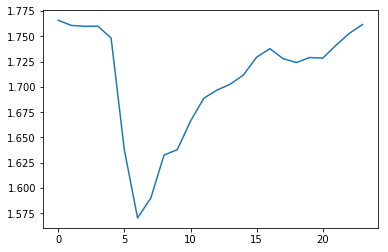

In [0]:
linea.compute()

Promedio General para **día de la semana**.

In [0]:
linea = graficas9(ddf)

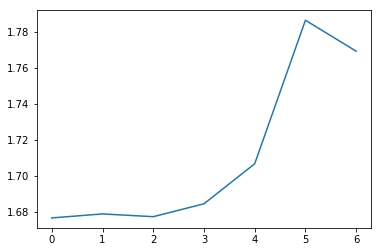

In [0]:
linea.compute()

In [0]:
grafica91(ddf)

### Redención

In [0]:
!pip install partd

In [0]:
ddg = ddf.groupby(['month', 'weekday'])
ddgh = ddf.groupby(['month', 'hour'])

In [0]:
ddf.head()

,Unnamed: 0,medallion,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,path,duracion,month,weekday
0,0.0,89D227B655E5C82AECF13C3F540D4CF4,2013-01-01 15:11:48,2013-01-01 15:18:10,4.0,382.0,1.0,-73.978165,40.757977,-73.989838,40.751171,/content/gdrive/My Drive/SD/Datos/trip_data_1.csv,00:06:22,1,1
1,1.0,0BD7C8F5BA12B88E0B67BED28BEA73D8,2013-01-06 00:18:35,2013-01-06 00:22:54,1.0,259.0,1.5,-74.006683,40.731781,-73.994499,40.750660,/content/gdrive/My Drive/SD/Datos/trip_data_1.csv,00:04:19,1,6
2,2.0,0BD7C8F5BA12B88E0B67BED28BEA73D8,2013-01-05 18:49:41,2013-01-05 18:54:23,1.0,282.0,1.1,-74.004707,40.737770,-74.009834,40.726002,/content/gdrive/My Drive/SD/Datos/trip_data_1.csv,00:04:42,1,5
3,3.0,DFD2202EE08F7A8DC9A57B02ACB81FE2,2013-01-07 23:54:15,2013-01-07 23:58:20,2.0,244.0,0.7,-73.974602,40.759945,-73.984734,40.759388,/content/gdrive/My Drive/SD/Datos/trip_data_1.csv,00:04:05,1,0
4,4.0,DFD2202EE08F7A8DC9A57B02ACB81FE2,2013-01-07 23:25:03,2013-01-07 23:34:24,1.0,560.0,2.1,-73.976250,40.748528,-74.002586,40.747868,/content/gdrive/My Drive/SD/Datos/trip_data_1.csv,00:09:21,1,0


Promedio

In [0]:
prom_pasajeros_dia_hora = ddg.agg({'passenger_count' : ['mean']})

In [0]:
%%time
prom_pasajeros = prom_pasajeros_dia_hora.compute()

CPU times: user 12min 4s, sys: 35.1 s, total: 12min 40s
Wall time: 9min 15s


In [0]:
prom_pasajeros.columns = ['pasajeros']

Total por hora

In [0]:
%%time
total_pasajeros_hora = ddgh.agg({'passenger_count' : ['sum']})
total_pasajeros_h = total_pasajeros_hora.compute()
total_pasajeros_h.columns = ['pasajeros']

CPU times: user 13min 52s, sys: 42.3 s, total: 14min 34s
Wall time: 10min 18s


Total por día

In [0]:
total_pasajeros_dia_hora = ddg.agg({'passenger_count' : ['sum']})

In [0]:
%%time
total_pasajeros = total_pasajeros_dia_hora.compute()
prom_pasajeros.columns = ['pasajeros']

CPU times: user 12min 9s, sys: 35.1 s, total: 12min 44s
Wall time: 9min 28s


### Resultados

#### Promedio
En el promedio por mes, se puede notar que el mes de **Julio** es el mes que mejor inicia se desempeña en el promedio de los pasajeros que obtiene a lo largo de los días de la semana, mientras que septiembre es el que peor lo hace.

In [0]:
colores = ['r', 'g', 'b', 'y', 'k']

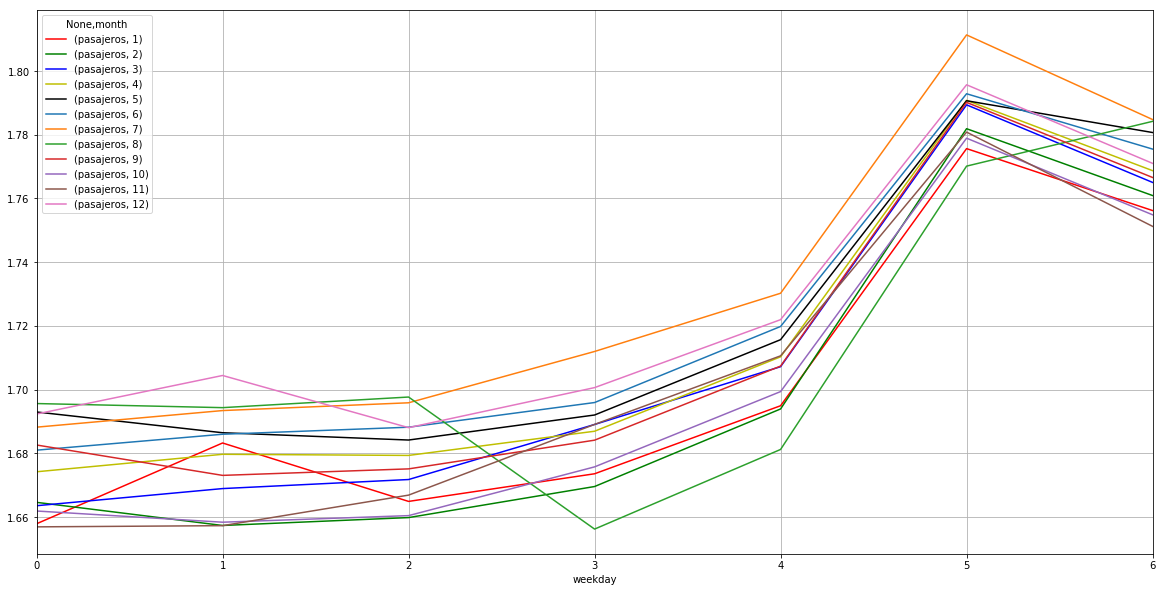

In [0]:
prom_pasajeros.unstack(level=0).plot(kind='line', style=colores, figsize=(20,10), grid=True);

#### Total de pasajeros agrupados por hora del día
En el total de pasajeros agrupados por día, **Febrero** es el mes que se mantiene más por debajo de los otros meses durante la mayor parte de los días, mientras que **marzo** es el mes que se mantiene por encima la mayor parte de los días de la semana.

Se nota también que las 5 de la mañana es el peor horario para trabajar, mientras que el mejor horarioson las 7 de la noche.

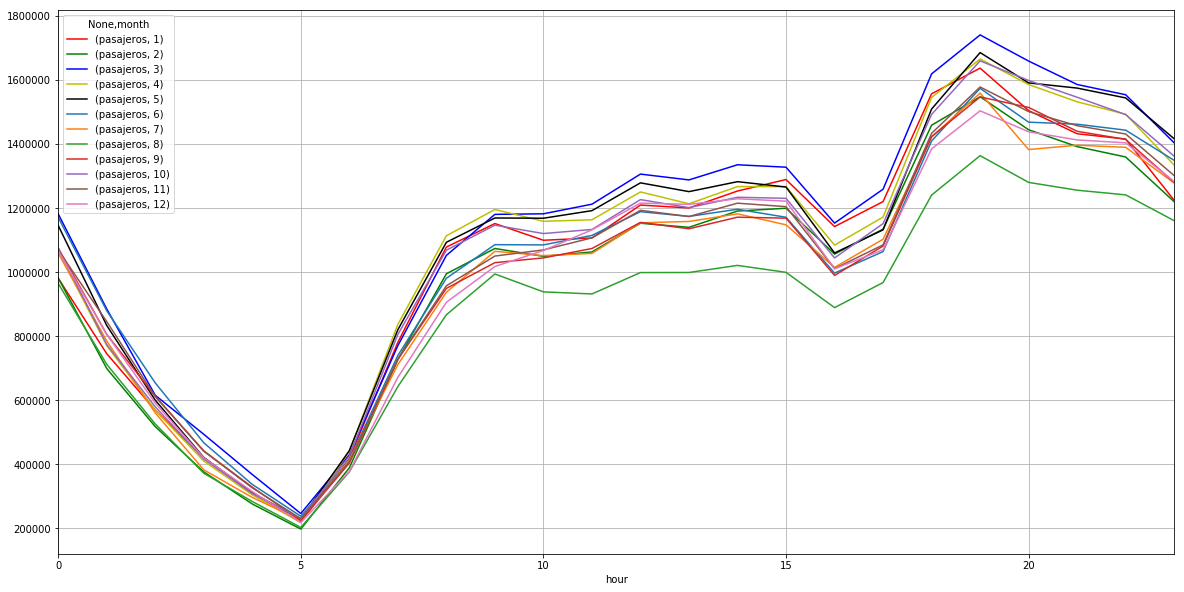

In [0]:
total_pasajeros_h.unstack(level=0).plot(kind='line', style=colores, figsize=(20,10), grid=True);

#### Total de pasajeros agrupados por día de la semana
En el total de pasajeros por días de la semana, **marzo** y **mayo** son los meses que mejor se desempeñan en la mayoría de los meses.

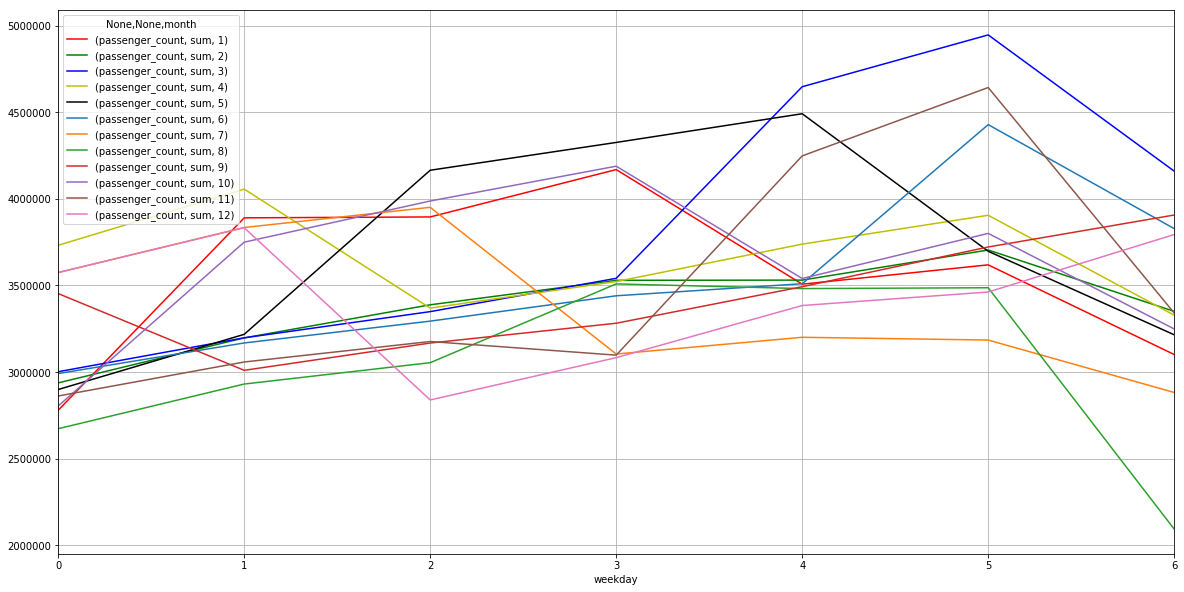

In [0]:
total_pasajeros.unstack(level=0).plot(kind='line', style=colores, figsize=(20,10), grid=True);

## 10. Elegir el vehiculo con mas viajes en cada mes y graficar en un mapa los sitios donde se suben pasajeros

### Conseguir mejores taxis
Tomando como medida los que tienen mayor cantidad de viajes.

In [0]:
ddf['month'] = dd.to_datetime(ddf['pickup_datetime']).dt.month

In [0]:
vehsum = ddf.groupby(['month', 'medallion']).agg({'passenger_count' : 'count'}).compute()
vehsum.columns = ['pasajeros']
vehsum = vehsum.reset_index()

In [0]:
mejores = vehsum.groupby(['month']).agg(lambda x:x.value_counts().index[0])
mejores = mejores.reset_index()

In [0]:
mejores

In [0]:
from pyproj import Proj, transform

def wmLongitud(longitud):
    mercator = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), longitud, 0)
    return mercator[0]

def wmLatitud(latitud):
    mercator = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 0, latitud)
    return mercator[1]

### Mapa

In [0]:
colores = ["red", "green", "blue", "gray", "pink", "orange"]
dias = ["Lunes", "Martes", "Miercoles", "jueves", "viernes","Sabado", "Domingo"]

In [23]:
!pip install pyproj

     |████████████████████████████████| 11.2MB 39.4MB/s 


In [0]:
import pyproj
from pyproj import Proj, transform
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN

In [0]:
transformacion = lambda x, y: transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), x, y)

In [0]:
NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

In [0]:
for fi in ac:
    print(fi[0])

In [0]:
mejores.to_numpy()

In [0]:
ddf.columns

Index(['Unnamed: 0', 'medallion', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'path', 'duracion', 'month', 'weekday'],
      dtype='object')

In [29]:
output_notebook()
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
ddf['weekday'] = dd.to_datetime(ddf['pickup_datetime']).dt.weekday

for taxi in mejores.to_numpy():
    print('Mes {}'.format(taxi[0]))
    mdf = ddf[ddf['month'] == taxi[0]]
    tdf = mdf[mdf['medallion'] == taxi[1]]
    ptdf = tdf.compute()
    ptdf["pickup_longitude"], ptdf["pickup_latitude"] = zip(*ptdf.apply(lambda x: transformacion(x["pickup_longitude"], x["pickup_latitude"]), axis=1))
    dia = ptdf.groupby('weekday')

    for i in range(0,6):
        ptdf = dia.get_group(i).sample(n=len(dia.get_group(i)))
        p.circle(x=ptdf["pickup_longitude"], y=ptdf["pickup_latitude"], legend=dias[i], fill_color=colores[i], line_color=None)

show(p)

Mes 1
Mes 2
Mes 3
Mes 4
Mes 5
Mes 6
Mes 7
Mes 8
Mes 9
Mes 10
Mes 11
Mes 12
